In [1]:
import sys
import os

from nlp_datasets import YahooDataset
from nlp_datasets import BaseDataset
from nlp_datasets import WordSim353Dataset
from nlp_modeltrainers import BaseTrainerModule
from nlp_metrics import Metrics

import torch
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.nn import Module, Linear, Embedding
from torch.utils.data import DataLoader

from scipy.stats import spearmanr
import fastwer

from nltk import word_tokenize

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from pytorch_lightning import LightningModule

dev = 'cpu'
if torch.cuda.is_available():
    dev = "cuda:0"

device = torch.device(dev)

In [ ]:
from utils.SubwordHash import subwordhash
from utils.SubwordEmbedding import subwordembedding
from utils.config import *

In [5]:
word_embedding = subwordembedding(num_embeddings = num_emb, embedding_dim = emb_dim, device = device, padding_idx = 0)
word_embedding.load_state_dict(torch.load(emb_path))
print(f'Loaded model: trained_model_{emb_dim}d_{epoch}')
print(word_embedding.num_embeddings)

Loaded model: trained_model_50d_100e
2000001


In [6]:
dataset = YahooDataset(max_samples=max_samples, local_dir="small_yahoo_dataset")
subword_hashes = subwordhash(dataset.train)

max_sw_hash_len = subword_hashes.max_hash
max_sample_len = subword_hashes.max_sample
print(max_sw_hash_len)
print(max_sample_len)

100%|█████████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:07<00:00, 1253.68it/s]


377
995


In [8]:
def similarity_eval(word_corpus, word_embedding, subword_hashes):
    mae = []
    less = []
    more = []
    similarities = []
    target_similarities = []
    if isinstance(word_corpus[0], dict):
        keys = list(word_corpus[0])
    else:
        keys = range(len(word_corpus[0]))
    for w in tqdm(word_corpus):
        w1 = subword_hashes(w[keys[0]])
        w2 = subword_hashes(w[keys[1]])
        subword_embed = word_embedding.subword_embedding(torch.tensor([w1,w2],dtype = torch.long)).to(device)
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).unsqueeze(1).to(device)
        model_sim = float(F.cosine_similarity(word_embed[0], word_embed[1]))
        similarities.append(model_sim)
        target_sim = 1 - fastwer.score_sent(w[0], w[1], char_level = True)/100
        target_similarities.append(target_sim)
        mae.append(abs(target_sim - model_sim))
        if target_sim - model_sim >=0:
            less.append(abs(target_sim - model_sim))
        elif target_sim - model_sim < 0:
            more.append(abs(target_sim - model_sim))
            
    print(f"MAE: {np.mean(mae)}")
    print(f"MAE (More): {np.mean(more)}")
    print(f"MAE (Less): {np.mean(less)}")
    plt.figure(figsize=[20,5])
    plt.plot(similarities)
    plt.plot(target_similarities)
#     plt.xticks(range(0,20), labels=range(1,21))
    plt.grid()
    plt.show()
    
def similarity_plot(word_embedding, max_char_len = 20):
    np.random.seed(0)
    words_num = 1000
    chars = list('qwertyuiopasdfghjklzxcvbnm')
    similarities = []
    target_similarities = []
    for char_len in tqdm(range(1,max_char_len +1)):
        g_words1 = ["".join(sampling_chars) for sampling_chars in np.random.choice(chars, size=[words_num, char_len], replace=True)]
        g_words2 = ["".join(sampling_chars) for sampling_chars in np.random.choice(chars, size=[words_num, char_len], replace=True)]
        
        gw1 = [subword_hashes(w) for w in g_words1]
        gw2 = [subword_hashes(w) for w in g_words2]
        subword_embed = word_embedding.subword_embedding(torch.tensor([gw1,gw2],dtype = torch.long)).to(device)
        g_word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).to(device)
        model_sim = F.cosine_similarity(g_word_embed[0], g_word_embed[1]).to(torch.device("cpu")).detach().numpy()
        similarities.append(model_sim.mean())
        target_sim = 1 - fastwer.score(g_words1, g_words2, char_level = True)/100
        target_similarities.append(target_sim)
    
    plt.figure(figsize=[20,5])
    plt.plot(similarities)
    plt.plot(target_similarities)
    plt.xticks(range(0,20), labels=range(1,21))
    plt.grid()
    plt.show()

In [7]:
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/words_corpus.txt", "r") as f:
    words_corpus = [line.split(":") for line in f.read().split("\n")]
    
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/anagram_corpus.txt", "r") as f:
    anagram_corpus = [line.split(":") for line in f.read().split("\n")]
    
with open("../NLP_Utilities/NLP_Datasets/datasets/spelling_similarity_corpus/misspellings_corpus.txt", "r") as f:
    misspellings_corpus = [line.split(":") for line in f.read().split("\n")]

100%|████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:01<00:00, 258.79it/s]


MAE: 0.4232867615405817
MAE (More): 0.12675614655017853
MAE (Less): 0.4244728840005433


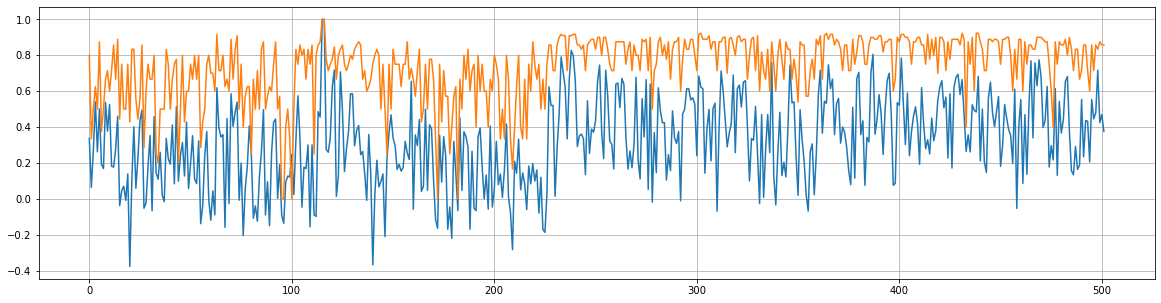

In [9]:
similarity_eval(misspellings_corpus, word_embedding, subword_hashes)

In [15]:
def semantic_eval(word_corpus, word_embedding, subword_hashes):
    spearman_corr = Metrics("Spearman")
    
    target_sim = []
    spearman_coef = []
    cosine_sim = []
    
    print(len(word_corpus))
    if isinstance(word_corpus[0], dict):
        keys = list(word_corpus[0])
    else:
        keys = range(3)
        
    for w in tqdm(word_corpus):
        sw1 = subword_hashes(w[keys[0]])
        sw2 = subword_hashes(w[keys[1]])
        subword_embed = word_embedding.subword_embedding(torch.tensor([sw1,sw2], dtype = torch.long))
        word_embed = subword_embed.sum(dim = len(subword_embed.shape) -2).unsqueeze(1).detach().numpy()
        correlation, _ = spearmanr(word_embed[0], word_embed[1], axis=1)
        spearman_coef.append(correlation)
        target_sim.append(w[keys[2]])
    plt.figure(figsize=[20,5])
    plt.plot(spearman_coef)
    plt.plot(target_sim)
    plt.grid()
    plt.show()
    

In [16]:
WS353ds = WordSim353Dataset(max_samples = max_samples, local_dir = "../datasets/WordSim353Dataset")
word_corpus = WS353ds.test

100%|██████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 709.12it/s]

35


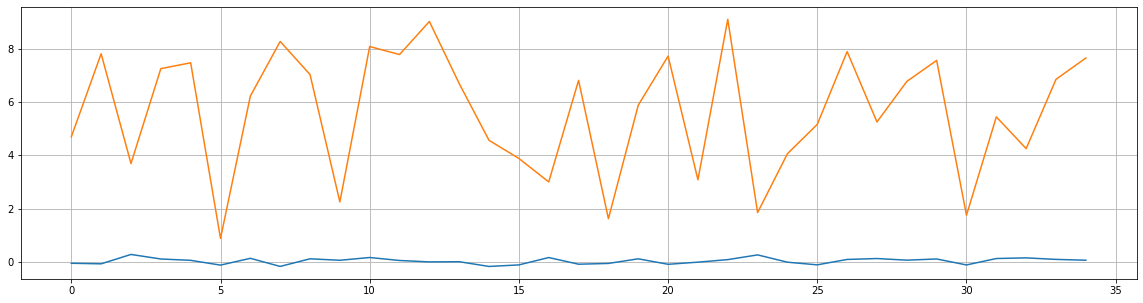

In [17]:
semantic_eval(word_corpus, word_embedding, subword_hashes)

##### a = Metrics('')

In [ ]:
misspellings_corpus[0]